#**Setup environment**

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!pip install dataclasses

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
_=download_url('https://storage.googleapis.com/ml_quantyca_it/pietro/chepizzai/data/pizzas.zip','./pizzas.zip',overwrite=True)

In [0]:
import zipfile
with zipfile.ZipFile('pizzas.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [0]:
data_dir = 'data/'

# **Verify Data**

In [0]:
classi = [f.path.split('/')[-1] for f in os.scandir(data_dir) if f.is_dir() ]    
for c in classi:
  print(c)
  verify_images(Path(data_dir)/c, delete=True)

tonno_e_cipolle


prosciutto


cannot identify image file <_io.BufferedReader name='data/prosciutto/prosciutto__0026.jpg'>
quattro_formaggi


diavola


tedesca


kebab


margherita


parmigiana


ortolana


tuple index out of range
salsiccia_e_friarelli


frutti_di_mare


prosciutto_e_funghi


crudo_rucola_grana


capricciosa


marinara


In [0]:
#rimozione immagine errata presente nel dataset, in attesa di rifare l'upload dello zip
import os
os.remove("data/diavola/diavola__0076.jpg")

# **View Data**

In [0]:
tfms = get_transforms([crop_pad(), rotate(degrees=(-45,45), p=0.5), brightness(change=(0.3, 0.7), p=0.5), contrast(scale=(0.5, 1.5), p=0.5), jitter(magnitude=0.5, p=0.5), symmetric_warp(magnitude=(-0.1,0.1), p=0.5), zoom(scale=1.25, p=0.5), cutout(n_holes=(1,4), length=(10, 160), p=0.75)])

In [0]:
np.random.seed(23)
bs = 64
data = ImageDataBunch.from_folder(Path(data_dir), train=".", valid_pct=0.2, 
                                  ds_tfms=tfms,
                                  size=224, bs=bs).normalize(imagenet_stats)                                  size=224, bs=bs).normalize(imagenet_stats)

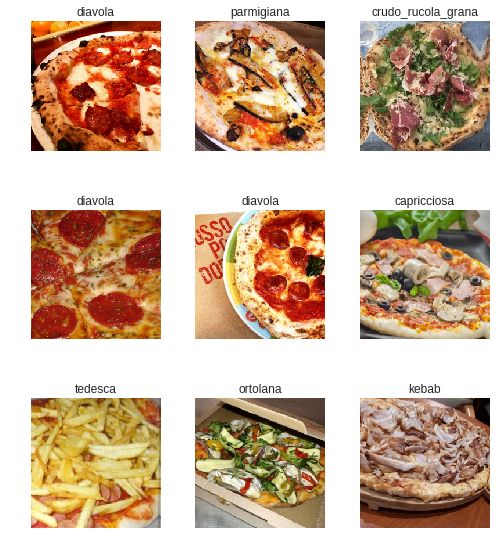

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['capricciosa',
  'crudo_rucola_grana',
  'diavola',
  'frutti_di_mare',
  'kebab',
  'margherita',
  'marinara',
  'ortolana',
  'parmigiana',
  'prosciutto',
  'prosciutto_e_funghi',
  'quattro_formaggi',
  'salsiccia_e_friarelli',
  'tedesca',
  'tonno_e_cipolle'],
 15,
 1111,
 277)

# **Train Model with Resnet34**

In [0]:
learn = create_cnn(data, models.resnet34, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 77384328.72it/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy
1,2.845981,1.723219,0.494585,0.505415
2,2.011594,0.981338,0.288809,0.711191
3,1.514930,0.837490,0.249097,0.750903
4,1.213919,0.818544,0.241877,0.758123


In [0]:
learn.save('res34-stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


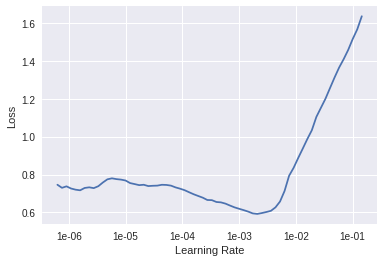

In [0]:
learn.load('res34-stage-1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.load('res34-stage-1')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.667050,0.602571,0.187726,0.812274
2,0.503085,0.515856,0.162455,0.837545


In [0]:
learn.save('res34-stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


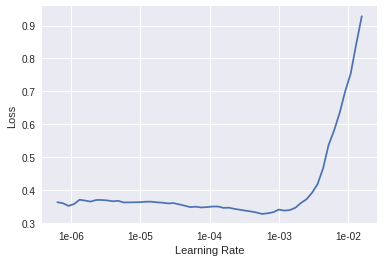

In [0]:
learn.load('res34-stage-2')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.load('res34-stage-2')
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.370179,0.511022,0.158845,0.841155
2,0.346477,0.486964,0.137184,0.862816
3,0.335740,0.479777,0.137184,0.862816
4,0.315414,0.477829,0.137184,0.862816


In [0]:
learn.save('res34-stage-3')

# **Interpretation**

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

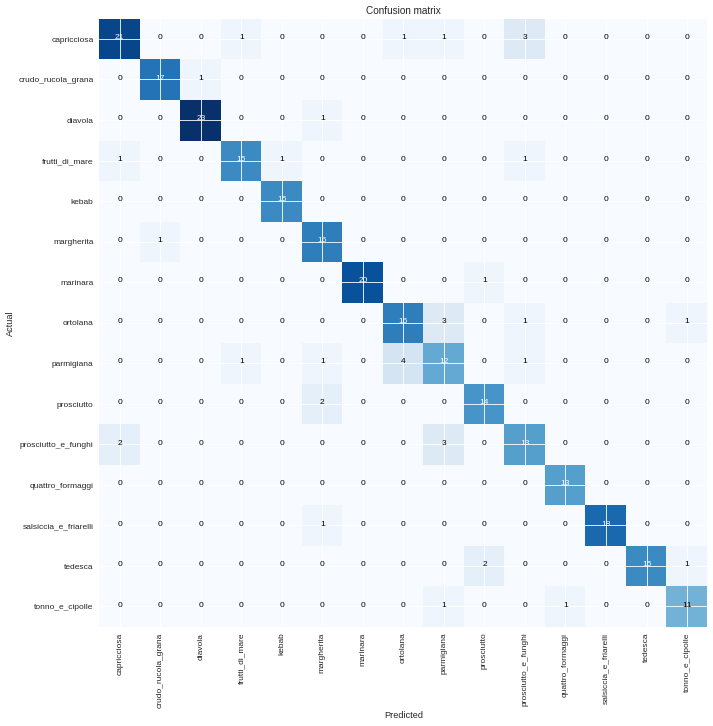

In [0]:
 interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=1)

[('parmigiana', 'ortolana', 4),
 ('capricciosa', 'prosciutto_e_funghi', 3),
 ('ortolana', 'parmigiana', 3),
 ('prosciutto_e_funghi', 'parmigiana', 3),
 ('prosciutto', 'margherita', 2),
 ('prosciutto_e_funghi', 'capricciosa', 2),
 ('tedesca', 'prosciutto', 2)]

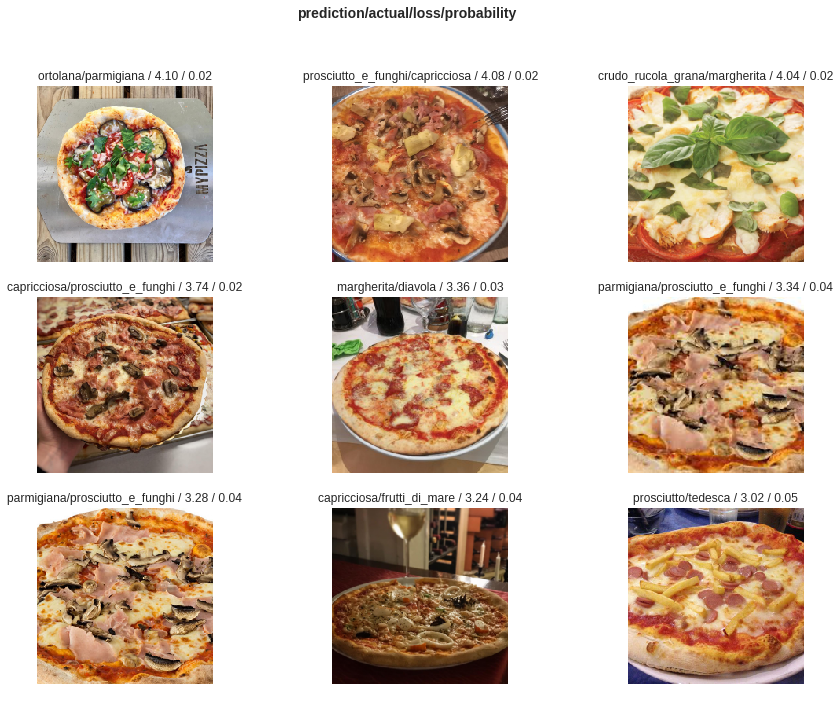

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

# **Train Model with Resnet50**

In [0]:
learn2 = create_cnn(data, models.resnet50, metrics=[error_rate, accuracy])
learn2.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy
1,2.285447,1.115048,0.353791,0.646209
2,1.450553,0.692032,0.212996,0.787004
3,1.041623,0.621986,0.209386,0.790614
4,0.814831,0.613287,0.216606,0.783394


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


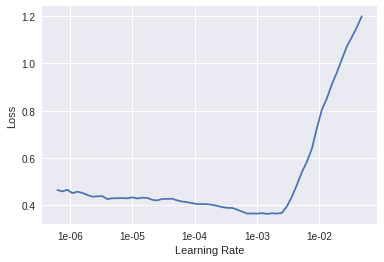

In [0]:
learn2.save('res50-stage-1')
learn2.unfreeze()
learn2.lr_find()
learn2.recorder.plot()

In [0]:
learn2.load('res50-stage-1')
learn2.unfreeze()
learn2.fit_one_cycle(2, max_lr=1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.417584,0.467159,0.155235,0.844765
2,0.319935,0.403084,0.140794,0.859206


In [0]:
learn2.save('res50-stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


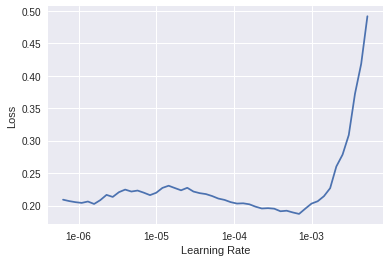

In [0]:
learn2.load('res50-stage-2')
learn2.unfreeze()
learn2.lr_find()
learn2.recorder.plot()

In [0]:
learn2.load('res50-stage-2')
learn2.unfreeze()
learn2.fit_one_cycle(2, max_lr=7e-5)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.209466,0.342981,0.111913,0.888087
2,0.174857,0.315526,0.104693,0.895307


# Interpretation Resnet50

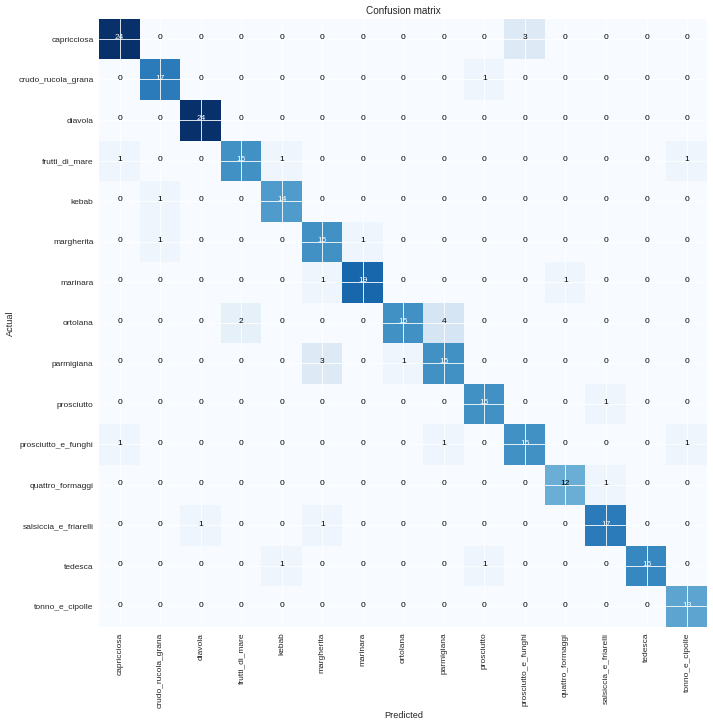

In [0]:
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp2.most_confused(min_val=1)

[('ortolana', 'parmigiana', 4),
 ('capricciosa', 'prosciutto_e_funghi', 3),
 ('parmigiana', 'margherita', 3),
 ('ortolana', 'frutti_di_mare', 2)]

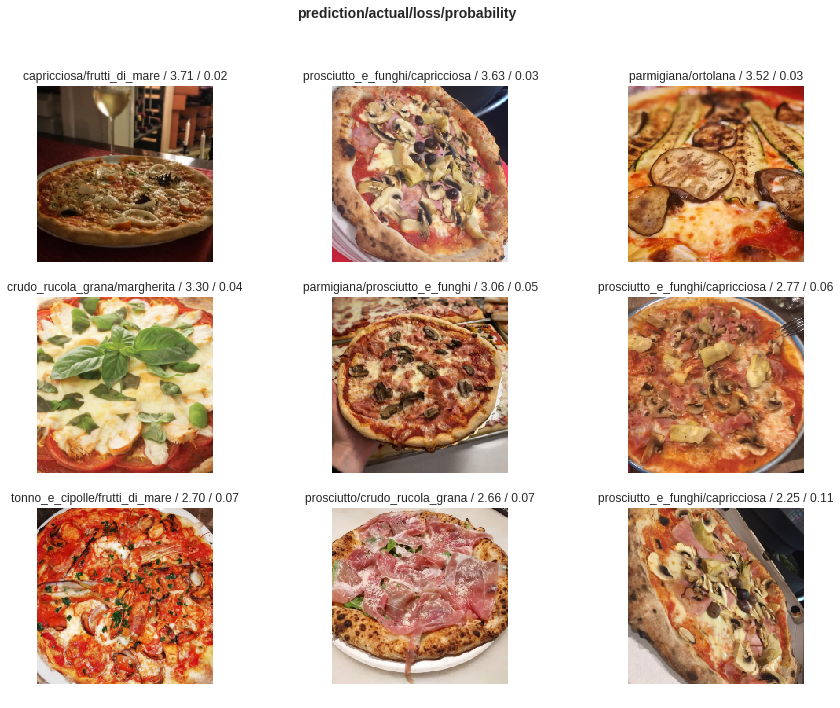

In [0]:
interp2.plot_top_losses(9, figsize=(15,11))